# Demand

PyPSA-GB uses the ESPENI (Elexon Sum Plus Embedded Net Imports) dataset from https://zenodo.org/record/3884859. This is a cleaned dataset using both National Grid and Elexon data to develop historical half hourly electricity profiles which represent the total system demand of the GB. Essentially, system view data (from Elexon) is added to embedded generation, i.e., distribution-connected solar and wind, and interconnector imports (both from National Grid). Therefore, generation at distribution level and interconnectors should be added separately. This is available from 2008-11-06 up to 2021-06-06 (as of 2021-06-17). See https://doi.org/10.1016/j.esr.2021.100743 for the paper Calculating Great Britain's half-hourly electrical demand from publicly available data which describes the methodology for deriving this dataset.

eLoad is a a load profile for 2050 which can be used to be more representative of the time-series variation of future electrical demand with heat pumps and EVs. See https://doi.org/10.1016/j.energy.2015.06.082 for formulation.

Load distribution across buses from the Future Energy Scenario Regional Breakdown worksheet. Historical years use 2020 distribution for all timeperiods.

Future demand profiles are generated by scaling historical demand profiles according to FES data specific to different scenarios.

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature

import imageio

from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point

from statistics import mean

import loads

## Historical data - ESPENI

Historical load data is included in the form of the ESPENI dataset. This provides the load profile for the whole GB power system. National Grid's FES2021 data includes a regional breakdown of projected demand by grid supply point which can be mapped to the nearest bus. The 2020 data for these regional breakdown is used to distribute the load across the buses for the historical years 2010-2020. The load distribution is plotted below for a three day period in December.

The ESPENI dataset is plotted for the entire dataset, over 2020, and over 01/01/2020.

In [3]:
df_loads = loads.read_historical_demand_data()
df_loads.rename(columns={'POWER_ESPENI_MW': 'load'}, inplace=True)
# add columns with year, month, and weekday name
df_loads['Year'] = df_loads.index.year
df_loads['Month'] = df_loads.index.month

Text(0, 0.5, 'Load [MW]')

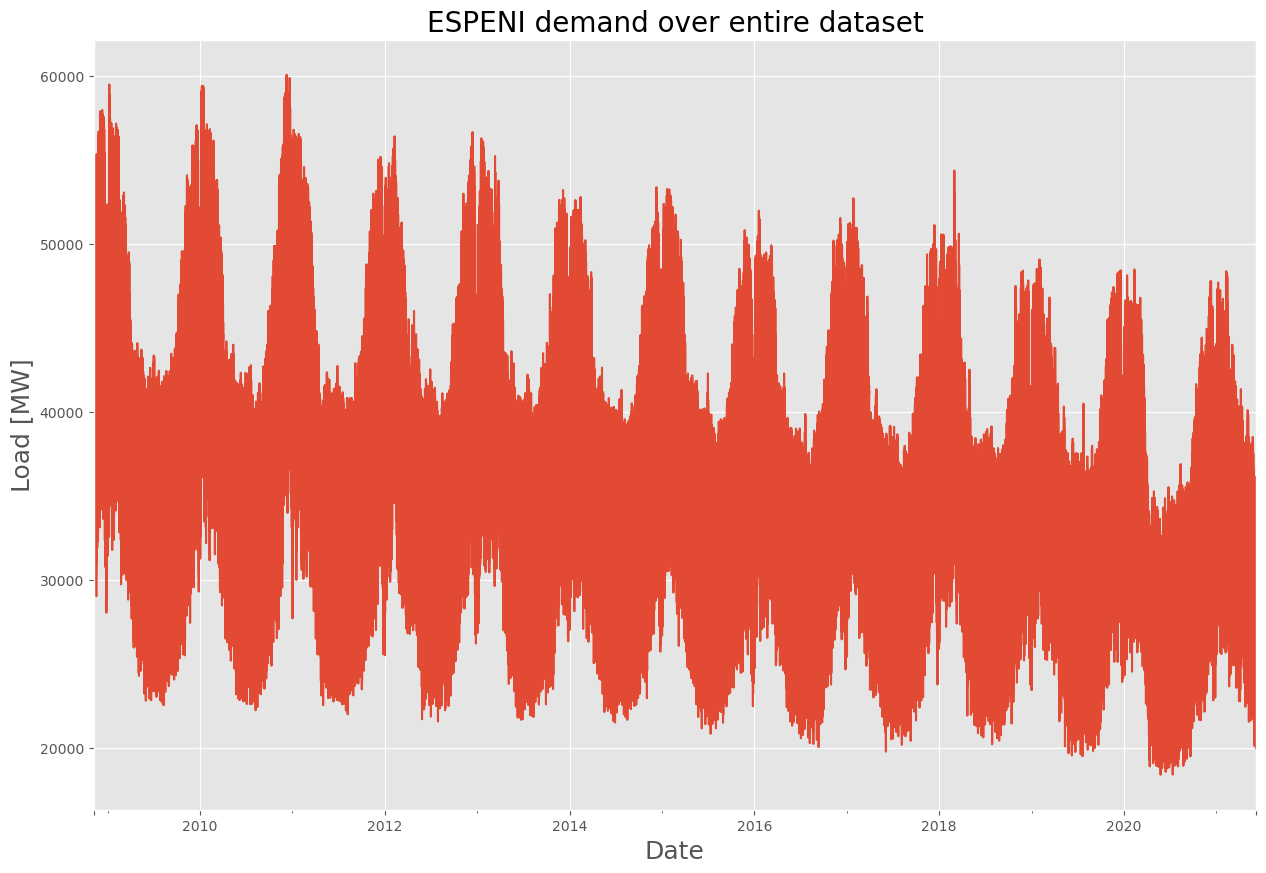

In [4]:
# Plot demand data
df_loads['load'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over entire dataset', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Load [MW]')

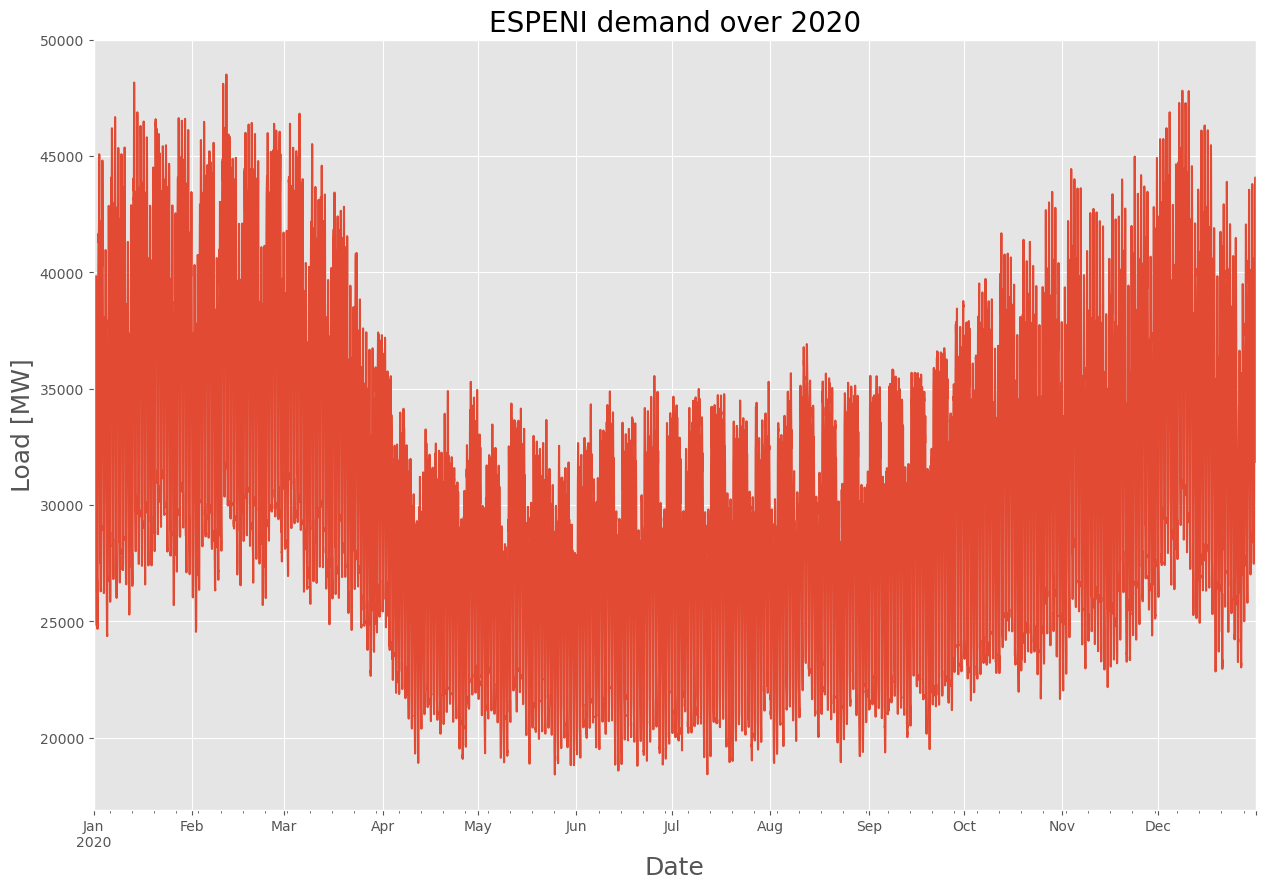

In [5]:
# Plot demand data
df_loads.loc['2020', 'load'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 2020', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Load [MW]')

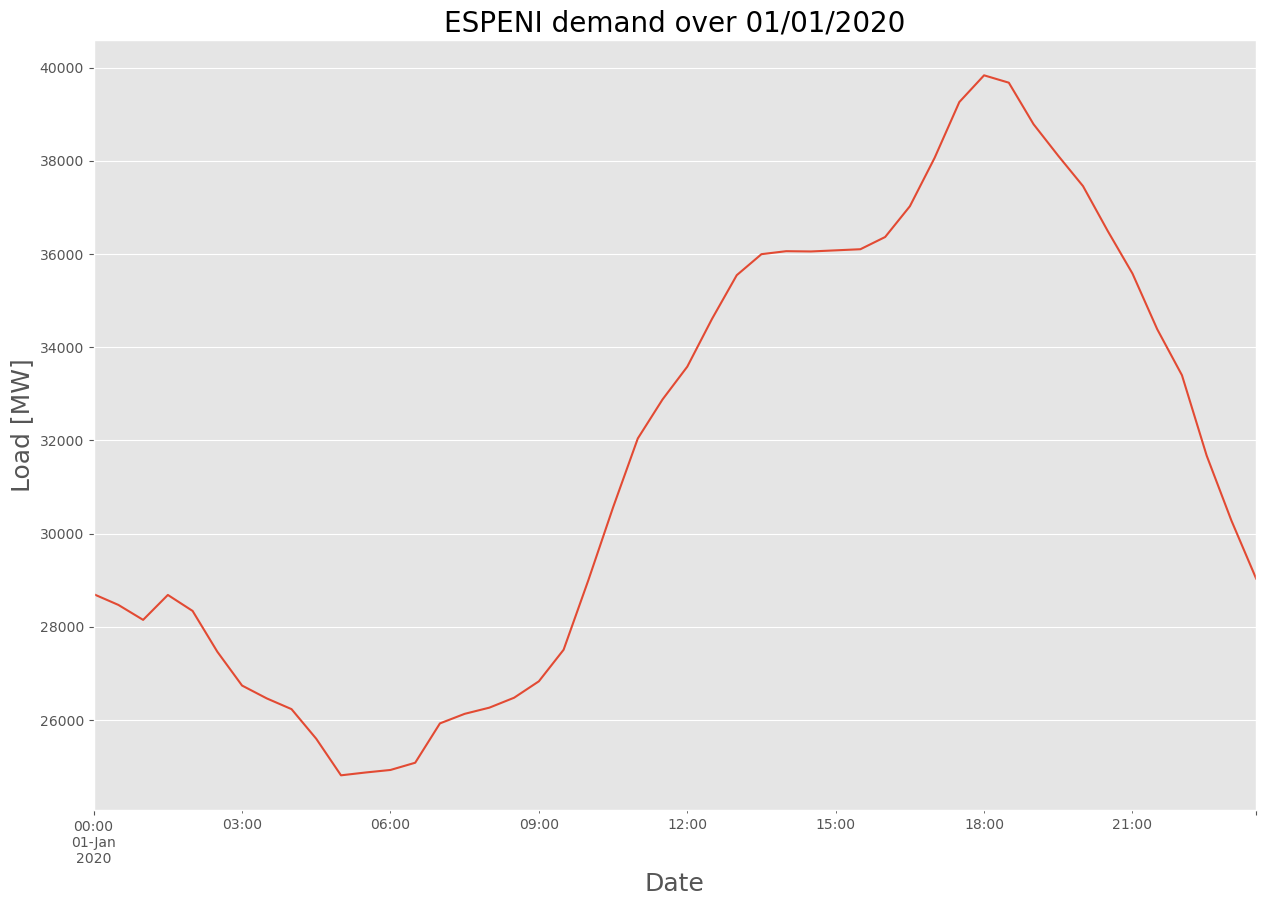

In [6]:
# Plot demand data
df_loads.loc['2020', 'load']['2020-01-01 00:00:00': '2020-01-01 23:30:00'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 01/01/2020', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Supply [kWh]')

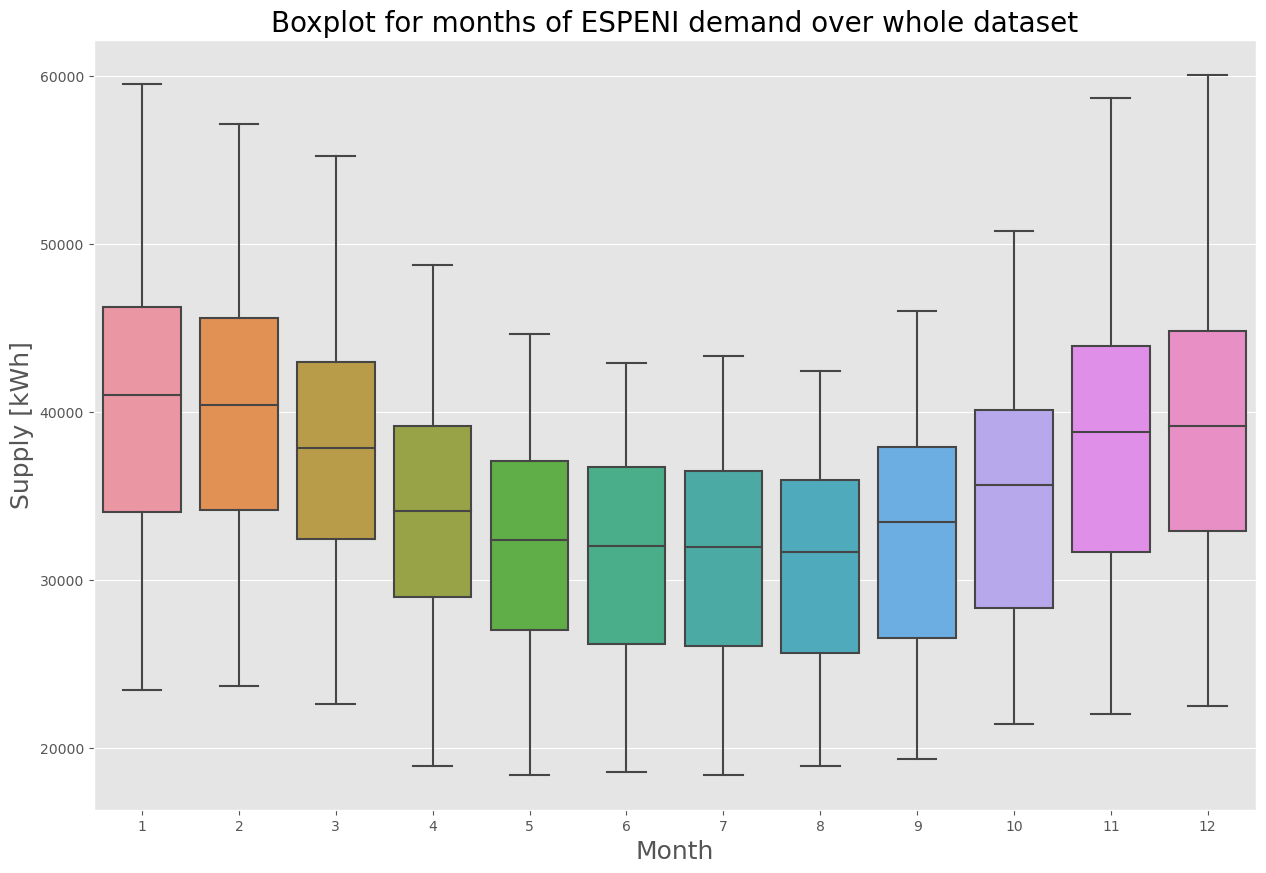

In [7]:
# Box plots over whole dataset for month values
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
sns.boxplot(data=df_loads, x='Month', y='load')
ax.set_title('Boxplot for months of ESPENI demand over whole dataset', fontsize=20)
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Supply [kWh]', fontsize=18)

## Future data - FES2021

Future demand profiles are generated by scaling historical demand profiles to match the projected annual load from the FES2021 dataset. Different demand profiles from historical years can be chosen, and this along with the use of weather data forms the baseline year used to simulate future years. 

Distributions across buses are also obtained from FES2021 where data is available for distributions for the years 2020-2050 and all four scenarios.

In [8]:
start = '2050-01-01 00:00:00'
end = '2050-12-31 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 1

year_baseline = 2019

loads.write_loads(year)
loads.write_loads_p_set(start, end, year, time_step, 'historical', year_baseline=year_baseline, scenario='Leading the Way', FES=2021)

df_loads = pd.read_csv('LOPF_data/loads-p_set.csv', index_col=0)

Text(0, 0.5, 'Load [MW]')

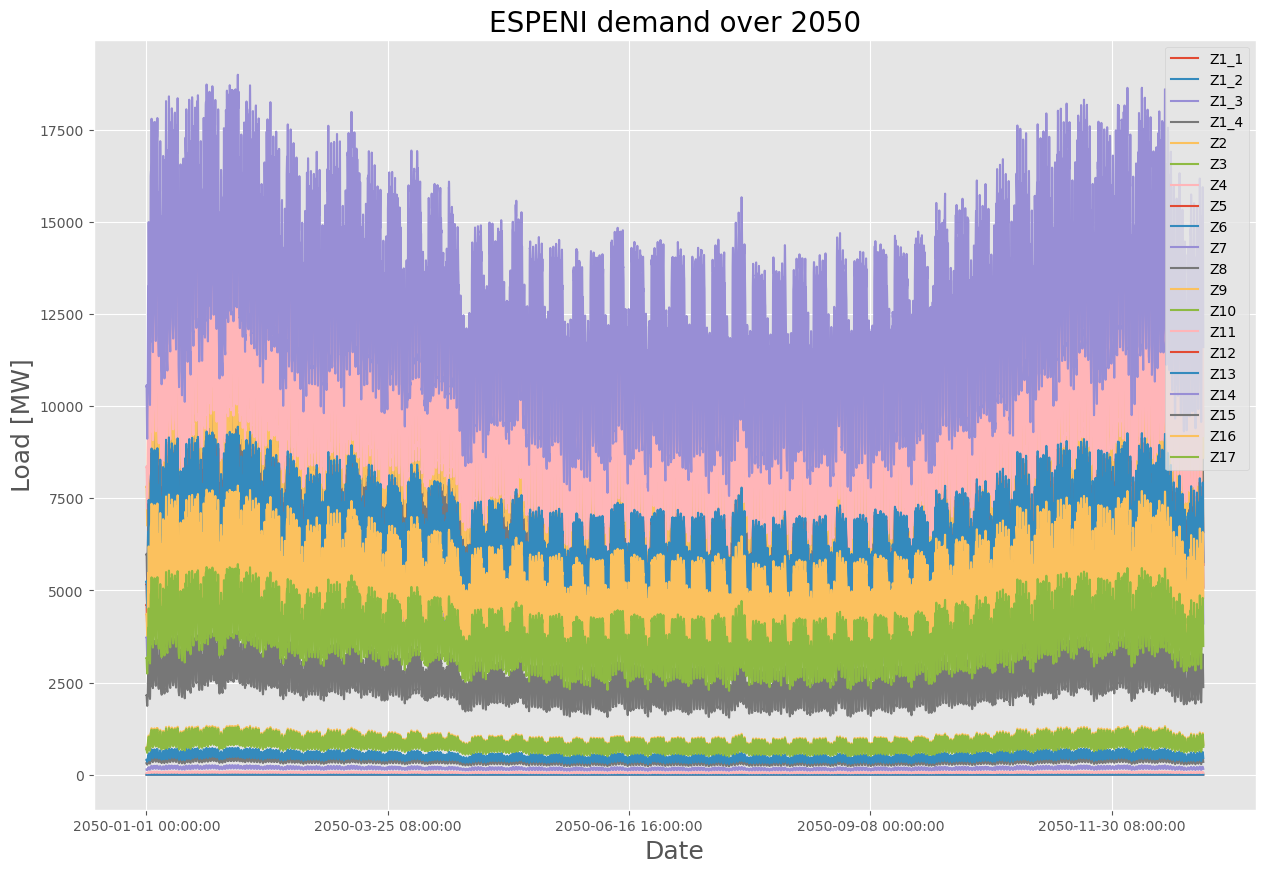

In [9]:
df_loads.plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 2050', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

In [10]:
df_loads['Total'] = df_loads.sum(axis=1)

Text(0, 0.5, 'Load [MW]')

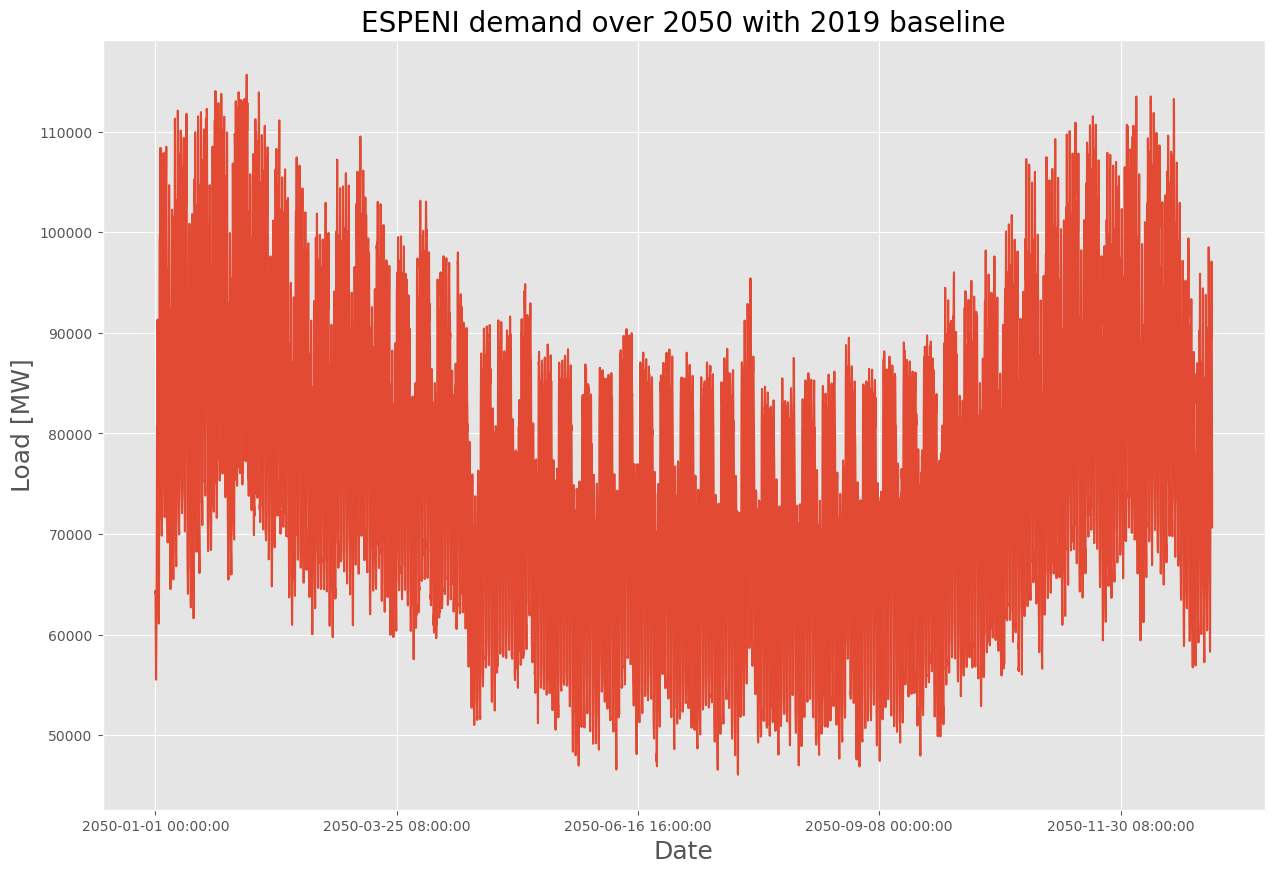

In [11]:
df_loads['Total'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 2050 with 2019 baseline', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

In [12]:
df_FES = pd.read_excel(
            '../data/FES2021/FES 2021 Data Workbook V04.xlsx',
            sheet_name='ED1', header=4, dtype=str)
df_FES_demand = df_FES.loc[df_FES['Data item'] == 'GBFES System Demand: Total']
scenario = 'Leading the Way'
df_FES_demand = df_FES_demand.loc[df_FES_demand['Scenario'] == scenario]
date = str(year) + '-01-01 00:00:00'
df_FES_demand.columns = df_FES_demand.columns.astype(str)
# future demand in GWh/yr
future_demand = df_FES_demand[date].values[0]
print(future_demand + ' GWh/year' + ' future total system demand in ' + str(year) + ' from FES2021 workbook')

686266 GWh/year future total system demand in 2050 from FES2021 workbook


In [13]:
print(str(round(df_loads['Total'].sum() / 2000, 0)) + ' GWh/year' + ' future total system demand in ' + str(year) + ' from checking dataframe by summing')

343133.0 GWh/year future total system demand in 2050 from checking dataframe by summing


## Peak loads

Scaling the load profile according to the annual energy demand to generate future load profiles results in overestimation of peak demands.

The analysis below shows the FES2021 data peak to be 94.7 GW, but the generated future load profile have a peak of 115.8 GW. Applying a moving average can reduce the peak demand to 99.2 GW. A smoothing algorithm is not currently applied.

In [14]:
# Leading the way, 2050 Electricity System ACS (Average Cold Spell) Peak Demand GW
peak_FES = 94.7

In [15]:
df_loads.max()

Z1_1          0.000000
Z1_2          0.000000
Z1_3        258.760538
Z1_4        568.820154
Z2         1347.766656
Z3         1306.594151
Z4           91.672117
Z5         8309.118013
Z6          735.109110
Z7         6716.981208
Z8        10773.605613
Z9        14077.799142
Z10        1235.441665
Z11       15039.690145
Z12        9316.312096
Z13        9443.960189
Z14       18992.650441
Z15        3891.268160
Z16        7844.894678
Z17        5714.317433
Total    115664.761508
dtype: float64

In [16]:
df_loads_smoothed = df_loads.rolling(48, min_periods=1).mean()
df_loads_smoothed.max()

Z1_1         0.000000
Z1_2         0.000000
Z1_3       221.440880
Z1_4       486.782243
Z2        1153.385426
Z3        1118.151012
Z4          78.450734
Z5        7110.738030
Z6         629.088225
Z7        5748.226665
Z8        9219.785666
Z9       12047.432902
Z10       1057.260472
Z11      12870.595472
Z12       7972.669857
Z13       8081.907943
Z14      16253.441289
Z15       3330.051209
Z16       6713.467162
Z17       4890.171763
Total    98983.046950
dtype: float64

Text(0, 0.5, 'Load [MW]')

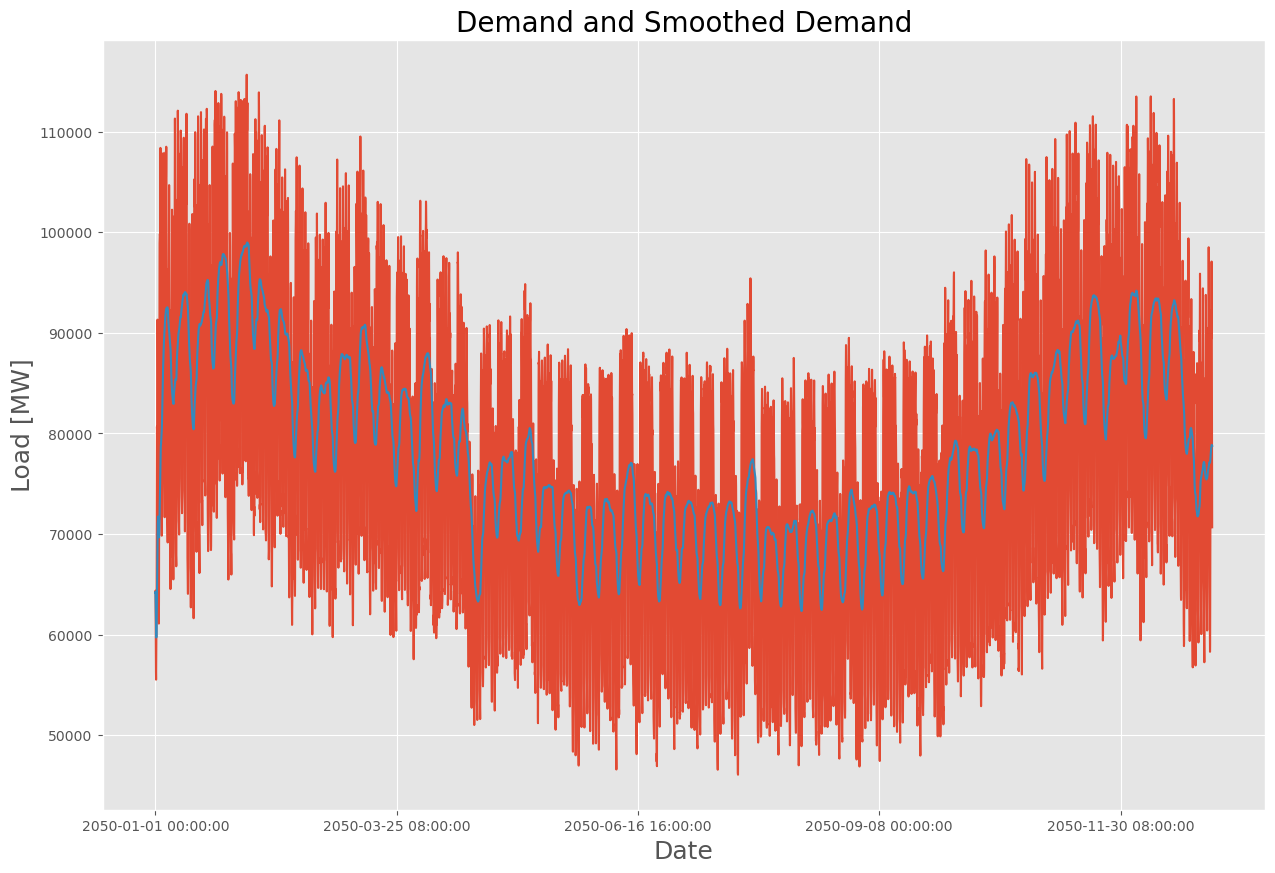

In [17]:
df_loads['Total'].plot(linestyle='-', figsize=(15,10))
df_loads_smoothed['Total'].plot(linestyle='-', figsize=(15,10))
plt.title('Demand and Smoothed Demand', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Load [MW]')

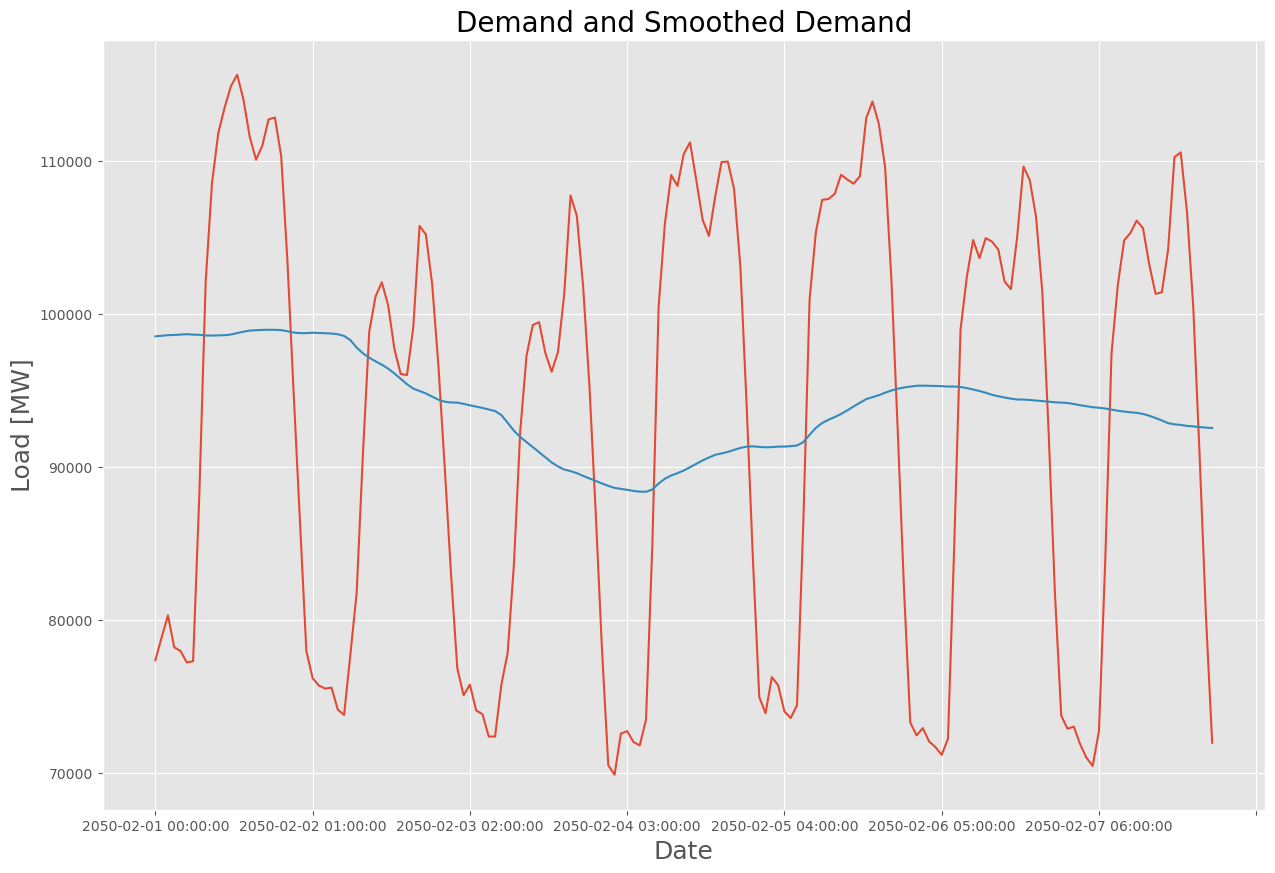

In [18]:
df_loads['Total']
date_from = '2050-02-01 00:00:00'
date_to = '2050-02-08 00:00:00'

df_loads['Total'].loc[date_from:date_to].plot(linestyle='-', figsize=(15,10))
df_loads_smoothed['Total'].loc[date_from:date_to].plot(linestyle='-', figsize=(15,10))
plt.title('Demand and Smoothed Demand', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

## eLoad for a future load profile

eLoad is a a load profile for 2050 which can be used to be more representative of the time-series variation of future electrical demand with heat pumps and EVs. See https://doi.org/10.1016/j.energy.2015.06.082 for formulation.

Text(0, 0.5, 'Load [MW]')

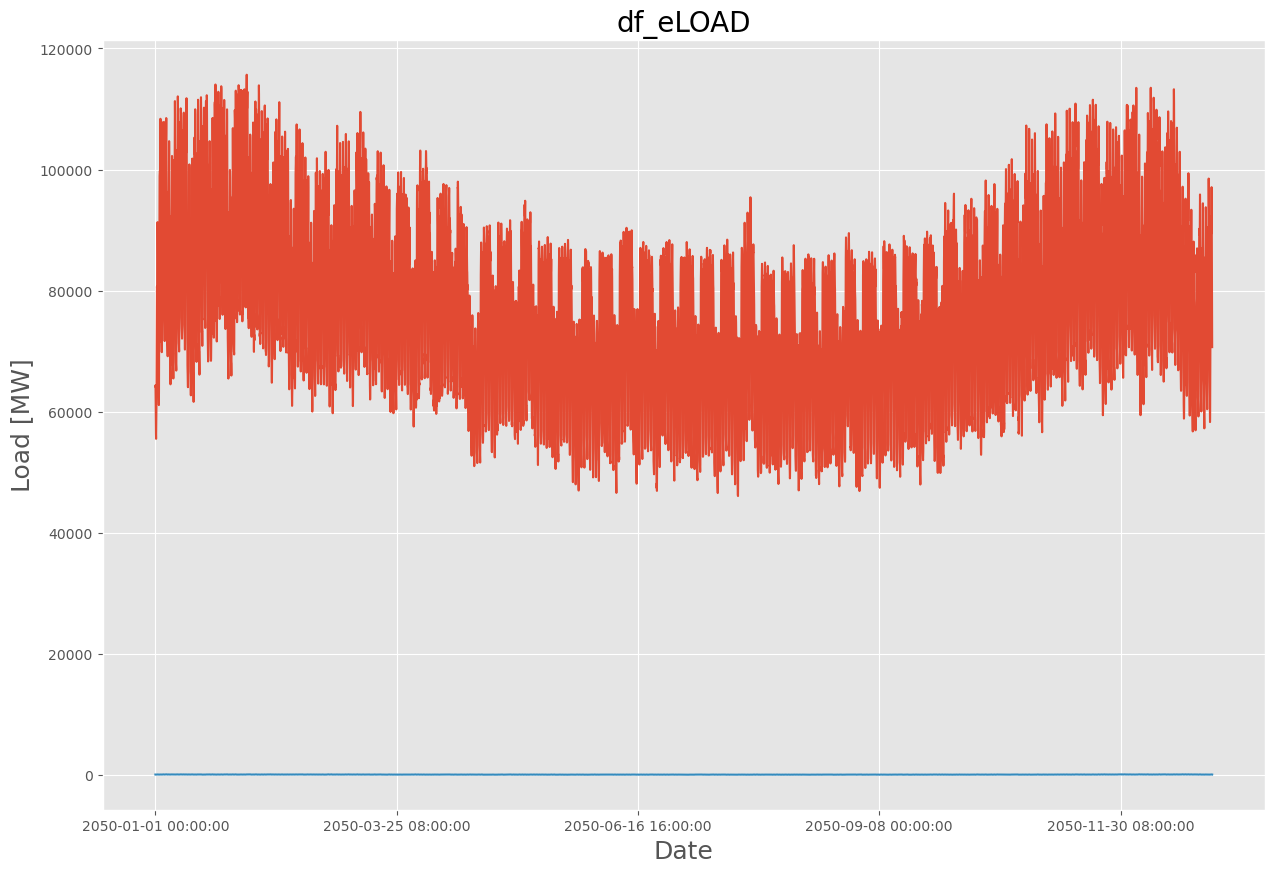

In [19]:
future_staffell_paper = pd.read_excel('../data/demand/egy_7649_mmc1.xlsb', sheet_name=None)
df_eLOAD = future_staffell_paper['ELOAD']['eLOAD Model (2050)'].drop([0,1,2,3,4,5])  # DESSTINEE is other demand model
df_eLOAD.index = df_loads.index
date_from = '2050-01-01 00:00:00'
date_to = '2050-12-31 23:30:00'

df_loads_downscaled = df_loads / 1000

df_loads['Total'].loc[date_from:date_to].plot(linestyle='-', figsize=(15,10))
df_eLOAD.loc[date_from:date_to].plot(linestyle='-', figsize=(15,10))
plt.title('df_eLOAD', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)